In [1]:
# Install the required libraries
!pip install transformers -q
!pip install torchaudio -q
!pip install nltk -q
!pip install pydub -q 

In [2]:
from transformers import AutoModelWithLMHead, AutoModelForCausalLM, AutoTokenizer
from transformers import WhisperForConditionalGeneration, WhisperConfig, WhisperProcessor
import torchaudio
import nltk
from pydub import AudioSegment
import re
from datasets import load_dataset

In [3]:
model_name = "openai/whisper-tiny.en"
model_config = WhisperConfig.from_pretrained(model_name)
processor = WhisperProcessor.from_pretrained(model_name)
asr_model = WhisperForConditionalGeneration.from_pretrained(model_name, config=model_config)

asr_model.eval()

WhisperForConditionalGeneration(
  (model): WhisperModel(
    (encoder): WhisperEncoder(
      (conv1): Conv1d(80, 384, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(384, 384, kernel_size=(3,), stride=(2,), padding=(1,))
      (embed_positions): Embedding(1500, 384)
      (layers): ModuleList(
        (0): WhisperEncoderLayer(
          (self_attn): WhisperAttention(
            (k_proj): Linear(in_features=384, out_features=384, bias=False)
            (v_proj): Linear(in_features=384, out_features=384, bias=True)
            (q_proj): Linear(in_features=384, out_features=384, bias=True)
            (out_proj): Linear(in_features=384, out_features=384, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
          (final_lay

In [4]:
ds = load_dataset("hf-internal-testing/librispeech_asr_dummy", "clean", split="validation")
sample = ds[0]["audio"]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset librispeech_asr downloaded and prepared to /root/.cache/huggingface/datasets/hf-internal-testing___librispeech_asr/clean/2.1.0/d3bc4c2bc2078fcde3ad0f0f635862e4c0fef78ba94c4a34c4c250a097af240b. Subsequent calls will reuse this data.


In [5]:
input_features = processor(sample["array"], sampling_rate=sample["sampling_rate"], return_tensors="pt").input_features 
transcript = asr_model.generate(input_features)

/opt/conda/lib/python3.7/site-packages/transformers/generation/utils.py:1278: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 448 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  UserWarning,


In [6]:
predicted_ids = asr_model.generate(input_features)
transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)

In [7]:
print(transcription[0])

 Mr. Quilter is the apostle of the middle classes, and we are glad to welcome his gospel.


In [8]:
lyrics = transcription[0]

In [9]:
from transformers import AutoModelWithLMHead, AutoTokenizer, set_seed, pipeline
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel

In [10]:
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelWithLMHead.from_pretrained(model_name)

/opt/conda/lib/python3.7/site-packages/transformers/models/auto/modeling_auto.py:1252: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


In [11]:
def generate_summary(lyrics):
    summarizer = pipeline("summarization", model="philschmid/bart-large-cnn-samsum")
    summary = summarizer(lyrics)
    return summary

In [12]:
# Set up GPT-2 model and tokenizer
model_name = 'gpt2'
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

In [13]:
# Set the device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
model = model.to(device)

In [15]:
summary_1 = generate_summary(lyrics)

Your max_length is set to 142, but you input_length is only 25. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


In [16]:
print(summary_1[0]['summary_text'])

Mr. Quilter is the apostle of the middle classes, and we are glad to welcome his gospel, writes Mr. Jannet. He is also a good friend of the people of the Middle Class.   He is a man of the clothings.


In [17]:
def generate_prompt(summary):
    # Generate prompt text using GPT-2
    prompt = f"Create an image that represents the feeling of '{summary}'"

    # Generate the image prompt
    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
    output = model.generate(input_ids, do_sample=True, max_length=100, temperature=0.7)
    prompt_text = tokenizer.decode(output[0], skip_special_tokens=True)
    
    return prompt_text

In [18]:
prompt_text_1 = generate_prompt(summary_1[0]['summary_text'])

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [19]:
print(prompt_text_1)

Create an image that represents the feeling of 'Mr. Quilter is the apostle of the middle classes, and we are glad to welcome his gospel, writes Mr. Jannet. He is also a good friend of the people of the Middle Class.   He is a man of the clothings.' In the following sentence, we are to read the words, 'Mr. John Quilter is the apostle of the middle classes, and we are glad to welcome his gospel, writes


In [20]:
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Tue Mar 14 19:03:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/

In [21]:
!pip install diffusers==0.11.1 -q
!pip install transformers scipy ftfy accelerate -q

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [22]:
import torch
from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", torch_dtype=torch.float16) 

Fetching 20 files:   0%|          | 0/20 [00:00<?, ?it/s]

The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


In [23]:
pipe = pipe.to("cuda")

In [24]:
import torch
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

In [25]:
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler, DPMSolverMultistepScheduler

# 1. Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# 2. Load the tokenizer and text encoder to tokenize and encode the text. 
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# 3. The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.7.layer_norm1.bias', 'vision_model.encoder.layers.15.layer_norm1.weight', 'vision_model.encoder.layers.6.self_attn.q_proj.weight', 'vision_model.encoder.layers.23.mlp.fc2.bias', 'vision_model.encoder.layers.22.mlp.fc2.weight', 'vision_model.encoder.layers.15.mlp.fc2.bias', 'vision_model.encoder.layers.9.mlp.fc1.weight', 'vision_model.encoder.layers.16.self_attn.q_proj.bias', 'vision_model.encoder.layers.8.self_attn.k_proj.bias', 'vision_model.encoder.layers.4.self_attn.v_proj.bias', 'vision_model.encoder.layers.9.layer_norm1.weight', 'vision_model.encoder.layers.19.mlp.fc2.weight', 'vision_model.encoder.layers.6.self_attn.k_proj.bias', 'vision_model.encoder.layers.8.layer_norm2.bias', 'vision_model.encoder.layers.11.self_attn.q_proj.weight', 'vision_model.embeddings.class_embedding', 'vision_model.encoder.layers.20.self_attn.q_proj.weight', 

In [26]:
from diffusers import LMSDiscreteScheduler

scheduler = DPMSolverMultistepScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

In [27]:
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device) 

In [28]:
# prompt = ["still of darth vader in the streets of cyberpunk 2077 facing the camera holding a lightsaber, volumetric lighting, neon lights, bokeh, octane render, cinematic overlay, style by denis villeneuve"]
prompt = prompt_text_1

height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion

num_inference_steps = 50            # Number of denoising steps

guidance_scale = 7.5                # Scale for classifier-free guidance

generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise

batch_size = 1

In [29]:
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

In [30]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]  

In [31]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

In [32]:
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)

In [33]:
scheduler.set_timesteps(num_inference_steps)

In [34]:
latents = latents * scheduler.init_noise_sigma

In [35]:
from tqdm.auto import tqdm
from torch import autocast

for t in tqdm(scheduler.timesteps):
  # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)

    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample

  0%|          | 0/50 [00:00<?, ?it/s]

In [36]:
# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents

with torch.no_grad():
    image = vae.decode(latents).sample

In [37]:
from PIL import Image

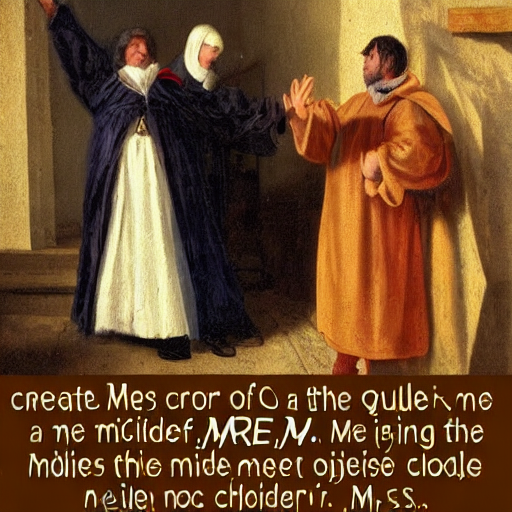

In [38]:
# DPM Solver Multistep scheduler
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]